# Dataset

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

import configparser
config = configparser.ConfigParser()
config.read("../config.ini")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PatientClinicalDataset(Dataset):
    """
    from csv, so getitem would be something like .loc[idx]
    """
    def __init__(self, csv_file_path):
        self.csv_file_path = csv_file_path
        self.df = pd.read_csv(self.csv_file_path).drop(["time", "event"], axis=1)

    def __getitem__(self, idx):
        patient_series = self.df.iloc[idx]
        return patient_series # includes the submitter_id!

    def __len__(self):
        return self.df.shape[0]


class PatientRNASeqDataset(Dataset):
    """
    a csv file, 534 rows and ~20000 columns for normalized RNA-seq counts
    """
    def __init__(self, rna_file_path):
        self.rna_file_path = rna_file_path
        self.df = pd.read_csv(self.rna_file_path)
        self.df.set_index("submitter_id", inplace=True)

    def __getitem__(self, case_id):
        gene_expressions = list(self.df.loc[case_id])
        tensor_gene_expressions = torch.tensor(gene_expressions, dtype=torch.float32).unsqueeze(0)
        return tensor_gene_expressions # [1, 19962]


class PatientWSIDataset(Dataset):
    """
    dataset for accessing a patient's list of patches features, each is of shape (1, n_patches, n_features)
    """
    def __init__(self, wsi_dir):

        self.wsi_dir = wsi_dir
        self.case_ids = list(os.listdir(self.wsi_dir))
        self.dict_case_id_path = {
            c: os.path.join(self.wsi_dir, c) + "/patches_features.npy" for c in self.case_ids
        }

    def __getitem__(self, case_id):
        # grab the list of 5 clusters for this case_id

        case_npy_file = self.dict_case_id_path[case_id]
        patches_features = np.load(case_npy_file, allow_pickle=True).item()
        
        cluster_ids = self.clustering(patches_features)

        features_list = list(patches_features.values())
        unique_clusters = np.unique(cluster_ids)
        n_clusters = len(unique_clusters)

        list_phenotype_tensors = [] # list of tensors, each tensor is a cluster's features of shape i.e. (1, 15 patches in this cluster, 512 as output of resnet18)

        for cluster in unique_clusters:
            cluster_features = [features for features, c in zip(features_list, cluster_ids) if c == cluster]
            tensor_cluster_features = torch.from_numpy(np.array(cluster_features)).float().unsqueeze(0) # (1, n_patches, n_features)

            list_phenotype_tensors.append(tensor_cluster_features.to(device))

        return list_phenotype_tensors # [t1,t2,t3,t4,t5]

    def clustering(self, patches_features, n_clusters=5):
        feature_vectors = list(patches_features.values())
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=50)
        cluster_ids = kmeans.fit_predict(feature_vectors)
        return cluster_ids

    def __len__(self):
        return len(self.case_ids)



## Fusion multimodal

class MultimodalDataset(Dataset):
    """
    takes three data paths (clinical, rna-seq, histopath images)
    build a data out of 'em
    """
    def __init__(self, 
        clinical_data_path, 
        rna_seq_data_path, 
        wsi_data_path
    ):
        # prepare labels from the clinical data path
        self.LABELS_DF = pd.read_csv(clinical_data_path)[["submitter_id", "event", "time"]]
        # then by initializing the clinical_dataset, remove the time and event from the clinical features:
        self.clinical_dataset = PatientClinicalDataset(clinical_data_path)

        # initialize the datasets for each modality
        self.wsi_dataset = PatientWSIDataset(wsi_data_path)
        self.rna_dataset = PatientRNASeqDataset(rna_seq_data_path)

        # label dictionary with key=submitter_id and value=(event,time) for easy lookup
        self.labels_dict = {}
        for submitter_id, event, time in zip(self.LABELS_DF["submitter_id"], self.LABELS_DF["event"], self.LABELS_DF["time"]):
            self.labels_dict[submitter_id] = {"event": event, "time": time}

    def __len__(self):
        return len(self.clinical_dataset)

    def __getitem__(self, idx):

        # (1) start from clinical dataset
        patient_series = self.clinical_dataset[idx]
        case_id = patient_series["submitter_id"]
        clinical_features = list(patient_series.drop(["submitter_id"]))
        tensor_clinical_features = torch.tensor(clinical_features, dtype=torch.float32).unsqueeze(0) 
        # above: add batch dim (1, 13) instead of (13)

        # (2) grab the tensor for 20000 (processed) gene counts for that case id
        tensor_rna_genes = self.rna_dataset[case_id] # (1, 19962)

        # (2.5) NOTE: to save time for this moment, I will concat the clinical and rna together 
        # and build one feed-forward for the combined
        tensor_clinical_rna = torch.cat((tensor_clinical_features, tensor_rna_genes), dim=1) # (1, 19975)

        # (3) collect the list of phenotype tensor for that case id
        list_of_phenotype_tensors = self.wsi_dataset[case_id]

        # (4) labels
        time = self.labels_dict[case_id]["time"]
        event = self.labels_dict[case_id]["event"]

        return (
            tensor_clinical_rna,
            list_of_phenotype_tensors,
            time,
            event
        )


In [ ]:
check_data = MultimodalDataset(
    config["clinical"]["cleaned_clinical_json"],
    config["rna"]["cleaned_rna"],
    config["wsi"]["wsi_slides"]
)

case0 = check_data[5]
clin_rna, list_tensors = case0[0], case0[1]

print("5 first gene counts:")
for i in clin_rna.flatten()[13:20]:
    print(i)

print("first 13 in clinical and rna:")
for i in clin_rna.flatten()[0:13]:
    print(i)

5 first gene counts:
tensor(2.4332)
tensor(0.)
tensor(3.4071)
tensor(2.7216)
tensor(1.6839)
tensor(1.7558)
tensor(3.9939)
first 13 in clinical and rna:
tensor(0.)
tensor(1.1109)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)


In [4]:
for tensor in list_tensors:
    print(tensor.shape)

print()
check_wsi = PatientWSIDataset(config["wsi"]["wsi_slides"])["TCGA-BP-4352"]
for tensor in check_wsi:
    print(tensor.shape)

torch.Size([1, 1148, 512])
torch.Size([1, 1078, 512])
torch.Size([1, 984, 512])
torch.Size([1, 966, 512])
torch.Size([1, 824, 512])

torch.Size([1, 1148, 512])
torch.Size([1, 1078, 512])
torch.Size([1, 984, 512])
torch.Size([1, 966, 512])
torch.Size([1, 824, 512])


# Model

In [ ]:
import numpy as np
import pandas as pd 
import random
import os
import math

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dropout_ratio = 0.5

class WSI_FCN(nn.Module):
    """
    https://arxiv.org/abs/2009.11169
    fully convolutional/connected network for WSI (2 experiments)
    takes 1 phenotype tensor/cluster of shape (1, n_patches, 512)
    outputs a local representation of that phenotype tensor of shape (1, 64)
    why FCN? on the numerical vectors? 
        - utilize the kernel, and especially kernel_size=1 because we can't have kernel_size>1 for randomly picked patches from the histopathology slides
        - so why not a simple fully connected network (MLP)? it's because it requires inputs with fixed dimension and we have varying number of patches for each cluster
    also, note that a patch -> FCN -> (1,64) shape. So if we have 300 patches or (300,64) shape, we would use avgpooling and get (1,64) as the final output for that cluster
    """
    def __init__(self, mode, in_features, out_features=64):
        super(WSI_FCN, self).__init__()

        self.mode = mode

        # Experiment 1: (closed March 4)
        self.conv = nn.Sequential(
            # conv1d because we only have a tensor of shape (N, C, L) = (1, 512, i.e. 272)
            nn.Conv1d(
                in_features, 
                out_features, 
                kernel_size=1 # kernel size = 1 is extremely important because we only want to the a single patch to be learned, 
                # doing i.e. 3x3 is no use because the patches are picked randomly, so can't use spatial relationship here
            ),
            nn.ReLU(),
            # adaptive avg pooling to get a local representation of the phenotype tensor
            # NOTE: adapative pooling from (64, 300 patches) to (64,1) as the final output of that cluster
            nn.AdaptiveAvgPool1d(1)
        )

        # Experiment 2: (start March 4)
        self.linear = nn.Sequential(
            # https://stackoverflow.com/a/58591606/19562762
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3), # NOTE tuning
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3), # NOTE tuning
            nn.Linear(128, out_features),
        )

    def forward(self, x):
        # input x: (1, n_patches, n_features)

        if self.mode == "conv":
            # permute to (1, n_features, n_patches) so that n_features become channels why? because tensor in pytorch reads () https://stackoverflow.com/questions/51541532/which-part-of-pytorch-tensor-represents-channels
            # n_patches is the length of the sequence. why?
            # FYI: for a conv2D, input should be in (N, C, H, W) format. N is the number of samples/batch_size. C is the channels. H and W are height and width resp: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d 
            # but here we have conv1d: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html#torch.nn.Conv1d
            x = x.permute(0, 2, 1) # (1, 512, 300 patches)
            # x = self.conv(x) # (1, 64, 300 patches)
            # x = self.relu(x) # (1, 64, 300 patches)
            # x = self.pool(x) # (1, 64, 1)
            x = self.conv(x)   # (1, 64, 1)
            x = x.view(x.size()[0], -1) # (1, 64)
            return x

        elif self.mode == "linear":
            x = self.linear(x) # (1, 64, 300 patches)
            x = torch.mean(x, dim=1) # (1,64) average
            return x # (1, 64)


class WSI_Attention(nn.Module):
    """
    https://arxiv.org/abs/2009.11169 
    pooling attention mechanism for WSI
    takes a local representation of the phenotype tensor of shape (5, 64) in which 5 is the number of clusters
    outputs a global representation of the phenotype tensors of shape (64-dim) which is a weighted sum across 5 clusters for 64 features
        each case has a global representation
    """
    def __init__(self, in_features, out_features=64):
        super(WSI_Attention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.Tanh(),  # tanh because we want to normalize the weights
            # why tanh() >> output values in range (-1,1), allowing both neg and pos values, often used in attention scores
            nn.Linear(out_features, 1),
        )

    def forward(self, x):
        # apply softmax because we have different number of clusters for each case
        # x: (5, 64) 
        # stack representation of 5 clusters/phenotypes
        scores = self.attention(x) # (5, 1)
        att_weights = torch.softmax(scores, dim=0).T # (1,5) which are probabilities
        # weighted sum across the 5 clusters:
        weights_applied = att_weights @ x  # (1, 64) = (1,5) @ (5,64)
        # weighted_sum_vector = torch.sum(weights_applied, dim=0) # (1, 64) or (64)
        return weights_applied, att_weights


class Clinical_RNA_FeedForward(nn.Module):
    def __init__(self, input_dim, output_dim=32, dropout_ratio=dropout_ratio):
        # https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
        # https://arxiv.org/pdf/1207.0580
        # For fully connected layers, dropout in all hidden layers works
        # better than dropout in only one hidden layer and more extreme probabilities tend to be worse,
        # which is why we have used 0.5 throughout this paper
        
        super(Clinical_RNA_FeedForward, self).__init__()

        # hidden = [512, 256, 256, 64, 64, 32]
        # hidden = [1024, 512, 512, 256, 256, 128, 128, 64, 64, 32]

        hidden = [1024, 1024, 512, 512, 256, 256, 128, 128, 64, 64, 32] # final: march 2, 2025

        self.feedforward = nn.Sequential(
            nn.Linear(input_dim, hidden[0]), nn.ReLU(), nn.Dropout(dropout_ratio),
            nn.Linear(hidden[0], hidden[1]), nn.ReLU(), nn.Dropout(dropout_ratio),
            nn.Linear(hidden[1], hidden[2]), nn.ReLU(), nn.Dropout(dropout_ratio),  
            nn.Linear(hidden[2], hidden[3]), nn.ReLU(), nn.Dropout(dropout_ratio),
            nn.Linear(hidden[3], hidden[4]), nn.ReLU(), nn.Dropout(dropout_ratio),
            nn.Linear(hidden[4], hidden[5]), nn.ReLU(), nn.Dropout(dropout_ratio),
            nn.Linear(hidden[5], hidden[6]), nn.ReLU(), nn.Dropout(dropout_ratio),
            nn.Linear(hidden[6], hidden[7]), nn.ReLU(), nn.Dropout(dropout_ratio),
            nn.Linear(hidden[7], hidden[8]), nn.ReLU(), nn.Dropout(dropout_ratio),
            nn.Linear(hidden[8], hidden[9]), nn.ReLU(), nn.Dropout(dropout_ratio),
            nn.Linear(hidden[9], hidden[10]), nn.ReLU(), nn.Dropout(dropout_ratio),
            nn.Linear(hidden[10], output_dim), nn.ReLU(), nn.Dropout(dropout_ratio),    
        )

    def forward(self, x):
        out = self.feedforward(x)
        return out


# FusionFeedForward
class FusionNetwork(nn.Module):
    def __init__(self, 
        input_dim_clinical_rna=19975, 
        input_dim_wsi_fcn=512, 
        input_dim_wsi_attention=64, 
        input_dim_final=96  # as from 32+64 = (out_dim of clinical_RNA) + (out_dim of WSI)
    ): 
        # NOTE: no dropout for now
        super(FusionNetwork, self).__init__()

        # Clinical+RNA
        self.clinical_rna_feedforward = Clinical_RNA_FeedForward(input_dim_clinical_rna, output_dim=32, dropout_ratio=dropout_ratio)
        # WSI_FCN and WSI_Attention
        self.wsi_fcn = WSI_FCN("linear", input_dim_wsi_fcn, out_features=64) # NOTE
        self.attention = WSI_Attention(input_dim_wsi_attention, out_features=64)

        # after fusion:
        # TODO: rational -> book: many hidden neurons are good -> with regularization like dropout/weight decay
        # for no. layers -> background knowledge and experimentation, for now 4 layers
        hidden = [64, 32, 16, 8]

        self.baby_feed_forward = nn.Sequential(
            nn.Linear(input_dim_final, hidden[0]),
            nn.ReLU(),
            nn.Linear(hidden[0], hidden[1]),
            nn.ReLU(),
            nn.Linear(hidden[1], hidden[2]),
            nn.ReLU(),
            nn.Linear(hidden[2], hidden[3]),
            nn.ReLU(),
            nn.Linear(hidden[3], 1)
        )

    def forward(self, tensor_clinical_rna, list_of_phenotype_tensors):

        # Clinical+RNA:
        extracted_clinical_rna = self.clinical_rna_feedforward(tensor_clinical_rna.to(device)) # (1, 32) shape
        
        # WSI_FCN
        local_reps = [] # len=5
        # here since tensors have different no. images in each of them
        # we use the "flexiblity" of the FCN to output 1x64 for each cluster
        for tensor in list_of_phenotype_tensors:
            tensor = tensor.to(device)
            cluster_rep = self.wsi_fcn(tensor) # each of shape (1,64) by pooling from tensors with varying dim
            local_reps.append(cluster_rep)
        # stack 5 local representation of shape (1,64) >> tensor of shape (5,64)
        tensor_local_reps = torch.cat(local_reps)

        # WSI_Attention:
        wsi_aggregated_vector, att_weights = self.attention(tensor_local_reps) # from (5,64) to weighted vector (1,64)

        # concantenate:
        concatenated_features = torch.cat((extracted_clinical_rna, wsi_aggregated_vector), dim=1) # shape (1, 96)

        risk_score = self.baby_feed_forward(concatenated_features)
        return risk_score


In [22]:
# sanity check

x = torch.rand(5, 64)
a2 = WSI_Attention(64)(x)
print(a2[0].shape)

x = torch.rand(1, 300, 512) # (1, n_patches, 512)
a1 = WSI_FCN("linear", 512)(x)
print(a1.shape)

x = torch.rand(1, 19975)
a3 = Clinical_RNA_FeedForward(19975)(x)
print(a3.shape)

x1 = torch.rand(1, 19975)
x2 = [torch.rand(1, 300, 512), torch.rand(1, 200, 512), torch.rand(1, 50, 512), torch.rand(1, 150, 512), torch.rand(1, 25, 512)]
m = FusionNetwork().to(device)
a4 = m(x1,x2)
a4, a4.shape

torch.Size([5, 64])
tensor([[-0.1001],
        [-0.0251],
        [-0.1315],
        [-0.1376],
        [-0.1129]], grad_fn=<AddmmBackward0>)
tensor([[0.2001, 0.2157, 0.1939, 0.1927, 0.1976]], grad_fn=<PermuteBackward0>)
torch.Size([1, 64])
torch.Size([1, 64])

torch.Size([1, 64])
torch.Size([1, 32])
torch.Size([5, 64])
tensor([[0.0851],
        [0.0853],
        [0.0864],
        [0.0900],
        [0.0903]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1995, 0.1996, 0.1998, 0.2005, 0.2006]], device='cuda:0',
       grad_fn=<PermuteBackward0>)
torch.Size([1, 64])


(tensor([[-0.1500]], device='cuda:0', grad_fn=<AddmmBackward0>),
 torch.Size([1, 1]))

# Training

In [26]:
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from datetime import datetime, date
from lifelines.utils import concordance_index
from utils import display_km_curves_fusion

# from models import *
# from data_utils import *

# import configparser
# config = configparser.ConfigParser()
# config.read("config.ini")

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

########################## LOSS ###############################################

def negative_partial_log_likelihood(hazard_preds, times, events, device, eps=1e-8):

    # This calculation credit to Travers Ching https://github.com/traversc/cox-nnet
    # Cox-nnet: An artificial neural network method for prognosis prediction of high-throughput omics data

    # flatten predictions
    hazard_preds = hazard_preds.view(-1)
    times = times.to(device).view(-1)
    events = events.to(device).view(-1)

    # uncensored patients ~ patients with event observed = 1
    # censored patients ~ not yet observed
    # if this batch only contains censored/alive patients:
    if events.sum() == 0:
        return torch.tensor(0.0, device=device)

    # compute risk set/matrix: R[i,j] = 1 if times[j] >= times[i]
    # https://stackoverflow.com/questions/56646261/can-someone-please-explain-np-less-equal-outerrange1-18-range1-13
    risk_matrix = torch.tensor(
        np.greater_equal.outer(times.cpu(), times.cpu()).T.astype(np.float32), 
        device=device
    )

    # standardize theta/hazard prediction
    theta = (hazard_preds - hazard_preds.mean()) / (hazard_preds.std(unbiased=False) + eps)

    # compute the log risk set using the correct formula
    # NOTE: use theta directly without an extra exp()
    # First, mask the non-risk set entries by multiplying exp(theta) with risk_matrix,
    # then take the log of the sum
    log_risk_set = torch.log(torch.sum(torch.exp(theta) * risk_matrix, dim=1) + eps)

    # negative partial likelihood only for events=1
    # only take the avg loss for the batch across patients in D=1
    loss = -torch.mean((theta - log_risk_set) * events)

    return loss

# one-batch
# hazard_pred = torch.tensor([2.1, 1.8, 3.0, 0.5, 2.5], device=device)
# time = torch.tensor([5, 3, 6, 2, 4], device=device)
# event = torch.tensor([1, 1, 0, 1, 0], device=device)

# one_batch_loss = negative_partial_log_likelihood(hazard_pred, time, event, device)
# print(one_batch_loss)

################## HYPERPARAMS ################################################

# https://arxiv.org/pdf/1206.5533 (guide to choose hyperparams)
n_epochs = 5
lr = 0.0001
batch_size = 32

# regularizations:
dropout_ratio = 0.5
weight_decay = 0.0001

# since we have relatively small dataset (~300 for training), high weidght decay may lead to udnerfitting
# but we might have many interactions between parameters in the final feedforward, so let's try different ones
# https://medium.com/towards-data-science/this-thing-called-weight-decay-a7cd4bcfccab
# https://stackoverflow.com/questions/44452571/what-is-the-proper-way-to-weight-decay-for-adam-optimizer

################### TRAIN #####################################################

def custom_collate(batch):
    """
    https://stackoverflow.com/questions/65279115/how-to-use-collate-fn-with-dataloaders 
    i.e. 32 batch_size
    batch = [
        (list_of_phenotype_tensors, time1, event1),    => case 1
        (list_of_phenotype_tensors, time2, event2),    => case 2
        ...                                            => case 32
    ]

    TODO: more explanation to come
    """
    # each element in batch is a tuple: 
    # (clinical_rna_tensor, list_of_phenotype_tensors, time, event)
    list_of_clinical_rna_features, list_of_lists_of_5_tensors, times, events = zip(*batch)
    # i.e. [patient_1_clinical_rna_t1, patient_2_clinical_rna_t2,..., patient32_clinical_rna_t32]
    # i.e. [[t1,t2,t3,t4,t5],[t1,t2,t3,t4,t5],...,[t1,t2,t3,t4,t5]] = [32 lists]
    
    return (
        list(list_of_clinical_rna_features),
        list(list_of_lists_of_5_tensors),
        torch.tensor(times),
        torch.tensor(events)
    )

# dataset and splitting
dataset = MultimodalDataset(
    config["clinical"]["cleaned_clinical_json"],
    config["rna"]["cleaned_rna"],
    config["wsi"]["wsi_slides"]
)

train_size, val_size = int(0.70 * len(dataset)), int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train, val, test = random_split(dataset, [train_size, val_size, test_size])

# loading data
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val, batch_size=val_size, shuffle=False, collate_fn=custom_collate)
test_loader = DataLoader(test, batch_size=test_size, shuffle=False, collate_fn=custom_collate)

# initiate model
model = FusionNetwork(
    input_dim_clinical_rna=19975,
    input_dim_wsi_fcn=512,
    input_dim_wsi_attention=64,
    input_dim_final=96
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


print("begin to train")
# training loops
for epoch in range(n_epochs):

    model.train()
    train_loss = 0.0 

    # each batch contains 32 cases!
    for batch in tqdm(train_loader):
        batch_clinical_rna_features, batch_lists_phenotype_clusters, batch_times, batch_events = batch

        risk_scores = [] # list of  32 risk scores
        for (clinical_rna_features, list_of_phenotype_tensors) in zip(batch_clinical_rna_features, batch_lists_phenotype_clusters):
            # process each sample in the batch of 32
            risk_score = model(clinical_rna_features, list_of_phenotype_tensors)
            risk_scores.append(risk_score)

        # convert to tensor type
        risk_scores = torch.stack(risk_scores) # of shape (batch_size, 1) or (32,1) 

        # TODO: explain in detail: meaning of loss of 32 cases in the batch
        optimizer.zero_grad() # zero the parameter gradients
        loss = negative_partial_log_likelihood(risk_scores, batch_times.to(device), batch_events.to(device), device)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # the lower the better i.e. the negative better better
    print(f"epoch {epoch}, loss: {train_loss / len(train_loader)}")

print("finished training\n")

cuda
begin to train


100%|██████████| 12/12 [14:52<00:00, 74.35s/it]


epoch 0, loss: 1.2118743360042572


100%|██████████| 12/12 [16:33<00:00, 82.79s/it]


epoch 1, loss: 1.150560900568962


100%|██████████| 12/12 [13:34<00:00, 67.84s/it]


epoch 2, loss: 1.0813533663749695


100%|██████████| 12/12 [10:32<00:00, 52.72s/it]


epoch 3, loss: 1.0543317993481953


100%|██████████| 12/12 [10:25<00:00, 52.16s/it]

epoch 4, loss: 1.033355380098025
finished training



In [27]:
####################### VALIDATION ############################################

print("begin to validate")
model.eval()

val_risks = []
val_times = []
val_events = []

with torch.no_grad():
    for batch in tqdm(val_loader):
        # unpack the batch
        batch_clinical_rna_features, batch_lists_phenotype_clusters, batch_times, batch_events = batch
        
        # move times and events to the device
        batch_times = batch_times.to(device)
        batch_events = batch_events.to(device)
        
        # tterate over each sample in the batch
        for idx, (clinical_rna_features, list_of_phenotype_tensors) in enumerate(zip(batch_clinical_rna_features, batch_lists_phenotype_clusters)):
            
            risk_score = model(clinical_rna_features, list_of_phenotype_tensors)
            
            val_risks.append(risk_score.item())
            val_times.append(batch_times[idx].item())
            val_events.append(batch_events[idx].item())


begin to validate


100%|██████████| 1/1 [02:06<00:00, 126.42s/it]


validation c-index: 0.6924564796905223
validation c-index custom: 0.6928294573643411


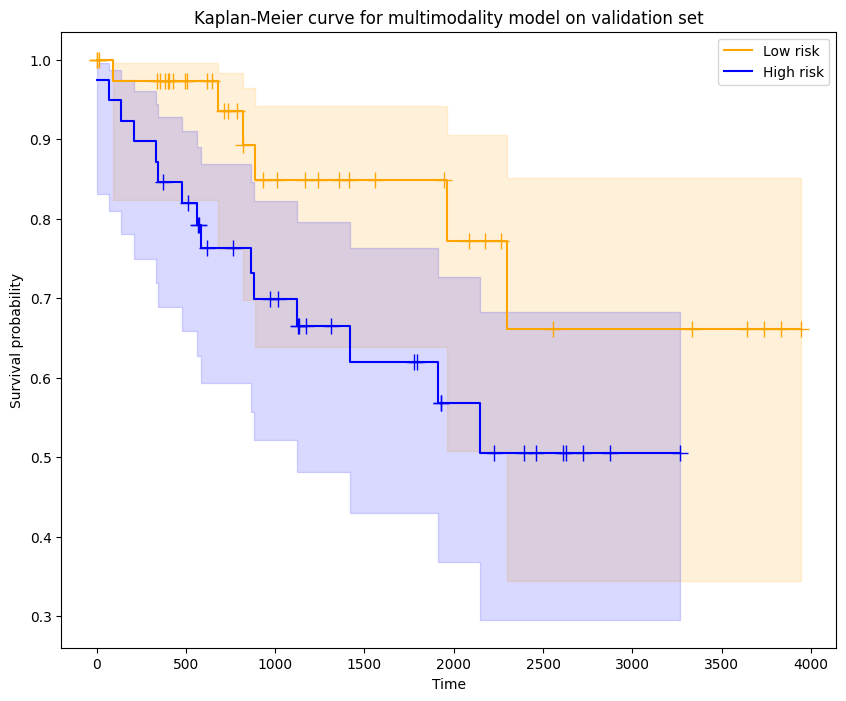

saved model: ../checkpoints/trained-model_2025-03-04_0.692456.pth


In [28]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

def display_km_curves_fusion(risks, times, events, title_name, c_index, save_figure=False):
    risks = np.array(risks)
    times = np.array(times)
    events = np.array(events)

    fig, ax = plt.subplots(figsize=(10, 8)) 
    high_risk_idx = risks > np.median(risks)
    low_risk_idx = risks <= np.median(risks)
    kmf_high = KaplanMeierFitter()
    kmf_low = KaplanMeierFitter()
    # fit low risk
    kmf_low.fit(times[low_risk_idx], event_observed=events[low_risk_idx], label='Low risk')
    kmf_low.plot_survival_function(ax=ax, ci_show=True, ci_alpha=0.15, show_censors=True, color='orange')
    # fit high risk
    kmf_high.fit(times[high_risk_idx], event_observed=events[high_risk_idx], label='High risk')
    kmf_high.plot_survival_function(ax=ax, ci_alpha=0.15, ci_show=True,show_censors=True, color='blue')
    ax.set_title(f"Kaplan-Meier curve for multimodality model on {title_name}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival probability")
    plt.legend()
    if save_figure:
        current_time = datetime.now().strftime("%H-%M-%S")
        plt.savefig(f"../evaluation-results/fusion_{title_name}_{date.today()}_{c_index:4f}.png")
    else:
        plt.show()

def concordance_index_custom(hazards, times, events):
    """
    computes the c-index for survival prediction
    - hazards: predicted risk scores (higher means higher risk)
    - times: observed survival times
    - events: event indicators (1 if event occurred, 0 if censored)
    """
    n = len(times)
    concordant = 0.0
    permissible = 0.0
    for i in range(n):
        for j in range(n):
            # only compare if i had an event and its time is earlier than j
            if times[i] < times[j] and events[i] == 1:
                permissible += 1
                if hazards[i] > hazards[j]:
                    concordant += 1
                elif hazards[i] == hazards[j]:
                    concordant += 0.5
    return concordant / permissible if permissible > 0 else 0


val_c_index = concordance_index(val_times, -np.array(val_risks), val_events)
print(f"validation c-index: {val_c_index}")

val_c_index_custom = concordance_index_custom(val_risks, val_times, val_events)
print(f"validation c-index custom: {val_c_index_custom}")

display_km_curves_fusion(val_risks, val_times, val_events, "validation set", val_c_index, save_figure=False)


saved_model = True

if saved_model:
    current_time = datetime.now().strftime("%H-%M-%S")
    checkpoint_path = f"../checkpoints/trained-model_{date.today()}_{val_c_index:4f}.pth"
    torch.save({
        'model_state_dict': model.state_dict(), # all weights all models
        'optimizer_state_dict': optimizer.state_dict(),
        'batch_size': batch_size,
        'dropout_ratio': dropout_ratio,
        'learning_rate': lr,
        'weight_decay': weight_decay,
        'n_epochs': n_epochs,
        'random_seed': 0,
        'val_c_index': val_c_index,
        'hidden': [1024, 1024, 512, 512, 256, 256, 128, 128, 64, 64, 32],
        'mode_fcn': 'linear'
    }, checkpoint_path)
    print(f"saved model: {checkpoint_path}")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22788\2694761428.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

test c-index: 0.7748279252704031


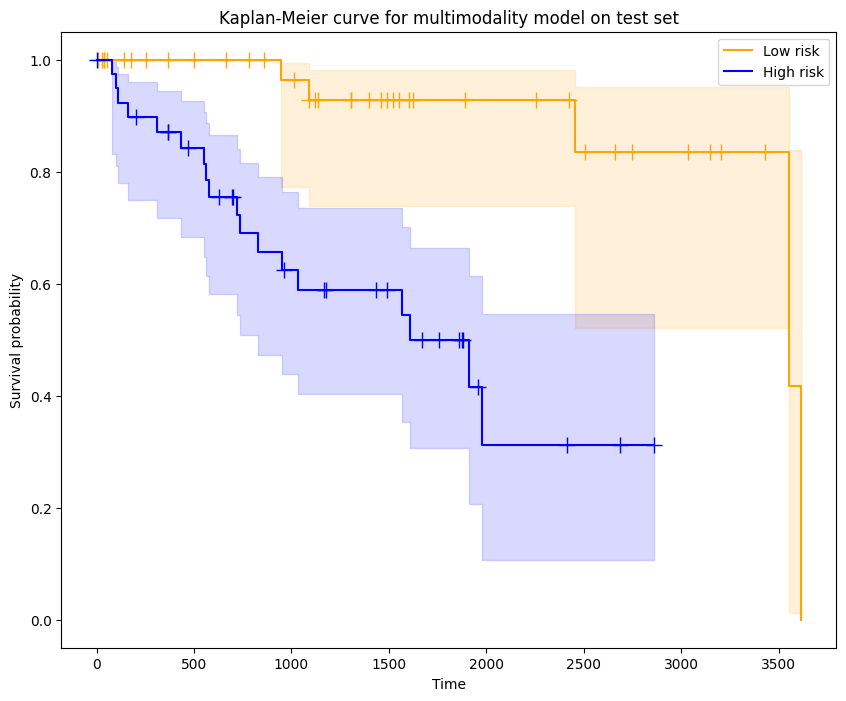

In [29]:
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import csv

from lifelines.utils import concordance_index

# from utils import display_km_curves_fusion
# from models import *
# from train import test_loader

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

############################# FINAL ###########################################

checkpoint_path = r"..\\checkpoints\trained-model_2025-03-04_0.692456.pth" # TODO: to choose

model_chkpt = FusionNetwork()
model_chkpt.to(device)
optimizer = optim.Adam(model_chkpt.parameters())

# load from last check point
checkpoint = torch.load(checkpoint_path, map_location=device)
model_chkpt.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
val_c_index = checkpoint['val_c_index']

model_chkpt.eval()

test_risks = []
test_times = []
test_events = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        # unpack the batch
        batch_clinical_rna_features, batch_lists_phenotype_clusters, batch_times, batch_events = batch
        
        # move times and events to the device
        batch_times = batch_times.to(device)
        batch_events = batch_events.to(device)
        
        # tterate over each sample in the batch
        for i, (clinical_rna_features, list_of_phenotype_tensors) in enumerate(zip(batch_clinical_rna_features, batch_lists_phenotype_clusters)):
            
            risk_score = model_chkpt(clinical_rna_features, list_of_phenotype_tensors)
            
            test_risks.append(risk_score.item())
            test_times.append(batch_times[i].item())
            test_events.append(batch_events[i].item())

test_c_index = concordance_index(test_times, -np.array(test_risks), test_events)
print(f"test c-index: {test_c_index}")
display_km_curves_fusion(test_risks, test_times, test_events, "test set", test_c_index, save_figure=True)

In [ ]:

def bootstrap_c_index(times, risks, events, n_bootstrap=300): # TODO: to choose
    random.seed(0)
    np.random.seed(0)

    indices = np.arange(len(times))
    bootstrap_scores = []

    for _ in range(n_bootstrap):
        # sample with replacement
        sample_indices = np.random.choice(indices, size=len(indices), replace=True)
        boot_times = np.array(times)[sample_indices]
        boot_risks = np.array(risks)[sample_indices]
        boot_events = np.array(events)[sample_indices]
        score = concordance_index(boot_times, -boot_risks, boot_events)
        bootstrap_scores.append(score)
        
    return np.mean(bootstrap_scores), np.std(bootstrap_scores)

mean_c_index, std_c_index = bootstrap_c_index(test_times, test_risks, test_events)
print(f"bootstrap mean c-index: {mean_c_index}, standard deviation: {std_c_index}")


bootstrap mean c-index: 0.7752918765296727, standard deviation: 0.04279807565228312


In [34]:
# append to csv file
with open("../evaluation-results/c-index-results.csv", "a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["model", "c-index"])
    writer.writerow({"model": "multimodality", "c-index": mean_c_index})